# GoodsForecast, команда mr MISISter

## Импортируем библиотеки

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from termcolor import colored

import tqdm
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
import seaborn as sns

import random
from catboost import CatBoostClassifier, Pool
import category_encoders as ce
import time
import pickle
import optuna

### Функции для обучения бустингов

In [4]:
def plot_roc_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    fpr, tpr, _ = roc_curve(y, proba)
    area = auc(fpr, tpr)
    
    # fig, ax = check_figax(fig, ax)
    fig.subplots_adjust(hspace=0.1)
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig


def plot_pr_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    prec, rec, thres = precision_recall_curve(y, proba)
    area = auc(rec, prec)
    
    # fig, ax = check_figax(fig, ax)
    
    ax.plot(rec, prec, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('PR curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig

def plot_confusion(y, pred_label, fig=None, ax=None, return_figure=False, fmt='d'):
    cm = confusion_matrix(y, pred_label)
    
    if ax is None:  # Check if ax is None, and if so, create a new figure and ax.
        fig, ax = plt.subplots(figsize=(8, 8))
        
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, fmt=fmt)
    
    ax.set_xlabel('\nPredicted values')
    ax.set_ylabel('\nActual values')
    
    if return_figure: return fig

def find_best_threshold(y, proba, method='f1'):
    if method == 'f1':
        prec, rec, thres = precision_recall_curve(y, proba, pos_label=1)
        f1 = 2 * prec * rec / (prec + rec)
        ind = np.nanargmax(f1)
        best_thres = thres[ind]
        
    elif method == 'J':
        fpr, tpr, thres = roc_curve(y, proba, pos_label=1)
        J = tpr - fpr
        ind = np.nanargmax(J)
        best_thres = thres[ind]
        
    return best_thres


def predict_proba_4eval_sets(clf, eval_sets):
    target_proba_sets = list()
    lst_feats = clf.feature_names_
    for i in range(len(eval_sets)):
        X, y = eval_sets[i]
        target_proba_sets.append((y, clf.predict_proba(X[lst_feats])[:, 1]))
        
    return target_proba_sets

def get_metrics_clf(target_proba_sets, eval_names, thres_method='f1'):
    n = len(target_proba_sets)
    metrics_df = list()
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        acc = accuracy_score(y, pred_label)
        f1 = f1_score(y, pred_label)
        prec = precision_score(y, pred_label)
        rec = recall_score(y, pred_label)
        roc_auc = roc_auc_score(y, proba)
        metrics_df.append(pd.DataFrame({'sample': [name],
                                        'roc_auc': [roc_auc],
                                        'Best thres': [best_thres],
                                        'F1': [f1],
                                        'Prec': [prec],
                                        'Rec': [rec]}))
    metrics_df = pd.concat(metrics_df, ignore_index=True)
    
    return metrics_df


def evaluation_clf(target_proba_sets, eval_names, roc_limits=None, pr_limits=None, thres_method='f1'):
    n = len(target_proba_sets)
    colors = [f'C{i}' for i in range(n)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax1, ax2 = ax.ravel()
    
    metrics_df = get_metrics_clf(target_proba_sets, eval_names)
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        color = colors[i]
        
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        plot_roc_curve(y, proba, label=name, color=color, sec_limits=roc_limits, fig=fig, ax=ax1, return_figure=False)
        fig = plot_pr_curve(y, proba, label=name, color=color, sec_limits=pr_limits, fig=fig, ax=ax2, return_figure=True)
        
    return fig, metrics_df

def build_cb_model(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                   verbose=50, seed=15, n_jobs=-1, fit_kwargs=None, task_type='binary'):
    
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose') or verbose
    params['random_state'] = params.get('random_state') or seed
    params['thread_count'] = params.get('thread_count') or n_jobs
    
    fit_kwargs =  {} if fit_kwargs is None else fit_kwargs.copy()
    
    if task_type == 'binary':
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
        
    elif task_type == 'regression':
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
    else:
        raise ValueError('task should be binary or regression')
        
    return model

def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_names_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_names_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start peplot_confurmutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_names_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [12]:
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.99):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [13]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compare_columns(df):
    columns = df.columns
    results = pd.DataFrame(index=columns, columns=columns)

    for col1 in tqdm.tqdm(columns):
        for col2 in columns:
            set1 = set(df[col1].dropna().unique())
            set2 = set(df[col2].dropna().unique())
            results.loc[col1, col2] = jaccard_similarity(set1, set2)

    return results

def get_unique_columns(similarity_matrix, threshold=0.26):

    columns_to_remove = set()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if isinstance(similarity_matrix, np.ndarray):
                value = similarity_matrix[i, j]
            else:  # Если это DataFrame
                value = similarity_matrix.iloc[i, j]
            if value >= threshold:
                columns_to_remove.add(j)

    # Получить названия удаленных колонок (если это DataFrame)
    if isinstance(similarity_matrix, pd.DataFrame):
        removed_column_names = [similarity_matrix.columns[i] for i in columns_to_remove]

    # Удалить дублирующиеся колонки из матрицы
    if isinstance(similarity_matrix, np.ndarray):
        updated_matrix = np.delete(similarity_matrix, list(columns_to_remove), axis=1)
        updated_matrix = np.delete(updated_matrix, list(columns_to_remove), axis=0)
    else:  # Если это DataFrame
        updated_matrix = similarity_matrix.drop(similarity_matrix.columns[list(columns_to_remove)], axis=1)
        updated_matrix = updated_matrix.drop(similarity_matrix.index[list(columns_to_remove)], axis=0)

    return updated_matrix


In [14]:
def get_samp_descr_for_binary_task(df, sample_col, date_col, target_col, feature_cols):
    sample_names = df[sample_col].unique()
    for name in sample_names:
        samp = df[df[sample_col] == name]
        print(colored(f'{name:}', None, attrs=['bold']))
        print('Period from:', samp[date_col].dt.date.min(), 'to', samp[date_col].dt.date.max())
        print('Target rate:', round(samp[target_col].mean(), 6))
        print('Count of target 1:', samp[target_col].sum())
        print('Shape of sample:', samp[feature_cols].shape)
        print('--------------------------------------------------------------------')

In [15]:
def custom_auc_scorer(model, X, y_true):
    y_pred = model.predict_proba(X)[:, 1] # Assuming binary classification
    return roc_auc_score(y_true, y_pred)

## Обучение catbooost (для IsCorrect is not Null)

In [21]:
data = pd.read_parquet('train_with_features6.parquet').drop(['Date', 'LocationId_ProductId', 'timestamp'], axis=1)
data.rename(columns={'ValidationDateTime': 'timestamp_train', 'IsCorrect': 'target'}, inplace=True)
ignore_features = ['ProductId', 'timestamp_train', 'LocationId', 'target']
corr_mx = data.drop(columns=ignore_features).corr()
nan_percentage = data.isna().mean()
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)
data.sort_values(by='timestamp_train', inplace=True)
df_no_corr = data.drop(corr_feats, axis=1).copy()
n_unique = df_no_corr.nunique()
cat_cols = [col for col in df_no_corr.columns if 1 < n_unique[col] < 10 and col != 'target'] + ['ProductId', 'LocationId']
cat_data = df_no_corr[cat_cols].astype('object')
compare_df = compare_columns(cat_data)
mat = get_unique_columns(compare_df)
cols_to_drop = list(set(cat_cols).difference(set(mat.columns)))
cols_to_drop += [col for col in df_no_corr.columns if n_unique[col] < 1]
model_df = df_no_corr.drop(cols_to_drop, axis=1).copy()
cat_cols = mat.columns

model_df['target'] = model_df['target'].astype('int')
model_df[cat_cols] = model_df[cat_cols].astype('object')

train_mask = model_df.timestamp_train < '2023-07-15'
valid_mask = (model_df.timestamp_train >= '2023-07-15') & (model_df.timestamp_train < '2023-07-17')
oot_mask = model_df.timestamp_train >= '2023-07-17'

sample = 'sample'
target = 'target'
date_col = 'timestamp_train'

model_df.loc[train_mask, sample] = 'train'
model_df.loc[valid_mask, sample] = 'valid'
model_df.loc[oot_mask, sample] = 'test'

model_df[target] = model_df[target].replace({True: 1, False: 0})

cat_cols = list(cat_cols)
num_cols = [col for col in model_df.columns if col not in cat_cols + [target, sample]]
feats = cat_cols + num_cols

get_samp_descr_for_binary_task(model_df, sample_col=sample, date_col=date_col, target_col=target, feature_cols=feats)

Get correlated features: 100%|██████████████| 369/369 [00:00<00:00, 4947.55it/s]


Column6 -> ['Column6' 'Column7']
Column11 -> ['Column11' 'Column13' 'mean_180_Quantity_sales' 'sum_180_Quantity_sales']
Column14 -> ['Column14' 'Column15' 'Column30' 'Column31' 'Column32' 'Column33'
 'Column38' 'Column39' 'Column53' 'Column54' 'Column55' 'Column56'
 'Column57']
Column19 -> ['Column19' 'Column45' 'Column49']
Column20 -> ['Column20' 'Column21']
Column21 -> ['Column20' 'Column21']
Column23 -> ['Column23' 'Quantity_stocks' 'mean_3_Quantity_stocks'
 'max_3_Quantity_stocks' 'min_3_Quantity_stocks' 'sum_3_Quantity_stocks'
 'mean_4_Quantity_stocks' 'max_4_Quantity_stocks' 'min_4_Quantity_stocks'
 'sum_4_Quantity_stocks' 'mean_5_Quantity_stocks' 'max_5_Quantity_stocks'
 'min_5_Quantity_stocks' 'sum_5_Quantity_stocks' 'mean_6_Quantity_stocks'
 'max_6_Quantity_stocks' 'min_6_Quantity_stocks' 'sum_6_Quantity_stocks'
 'mean_7_Quantity_stocks' 'max_7_Quantity_stocks' 'min_7_Quantity_stocks'
 'sum_7_Quantity_stocks' 'mean_180_Quantity_stocks'
 'max_180_Quantity_stocks' 'prev_1_Quanti

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  8.56it/s]


train
Period from: 2023-06-01 to 2023-07-14
Target rate: 0.16441
Count of target 1: 18235
Shape of sample: (110912, 130)
--------------------------------------------------------------------
valid
Period from: 2023-07-15 to 2023-07-16
Target rate: 0.568348
Count of target 1: 3875
Shape of sample: (6818, 130)
--------------------------------------------------------------------
test
Period from: 2023-07-17 to 2023-07-21
Target rate: 0.501187
Count of target 1: 9080
Shape of sample: (18117, 130)
--------------------------------------------------------------------


In [24]:
params = {'eval_metric': 'AUC', 'thread_count': 50}

In [25]:
clf = build_cb_model(model_df[train_mask][feats], model_df[train_mask].target,
                    model_df[valid_mask][feats], model_df[valid_mask].target,
                    cat_features=cat_cols, params=params)

Learning rate set to 0.101396
0:	test: 0.7576353	best: 0.7576353 (0)	total: 64.1ms	remaining: 1m 4s
50:	test: 0.8368250	best: 0.8368511 (49)	total: 1.51s	remaining: 28.1s
100:	test: 0.8437532	best: 0.8438120 (99)	total: 2.91s	remaining: 25.9s
150:	test: 0.8448379	best: 0.8465148 (137)	total: 4.2s	remaining: 23.6s
200:	test: 0.8440340	best: 0.8470968 (175)	total: 5.46s	remaining: 21.7s
250:	test: 0.8438197	best: 0.8470968 (175)	total: 6.75s	remaining: 20.1s
300:	test: 0.8446027	best: 0.8470968 (175)	total: 8s	remaining: 18.6s
350:	test: 0.8459643	best: 0.8470968 (175)	total: 9.22s	remaining: 17.1s
400:	test: 0.8452693	best: 0.8470968 (175)	total: 10.4s	remaining: 15.6s
450:	test: 0.8464599	best: 0.8470968 (175)	total: 11.7s	remaining: 14.2s
500:	test: 0.8459320	best: 0.8470968 (175)	total: 12.9s	remaining: 12.8s
550:	test: 0.8463081	best: 0.8470968 (175)	total: 14.1s	remaining: 11.5s
600:	test: 0.8452193	best: 0.8470968 (175)	total: 15.3s	remaining: 10.2s
650:	test: 0.8448422	best: 0.84

,sample,roc_auc,Best thres,F1,Prec,Rec
0,train,0.928286,0.310498,0.721740,0.735100,0.708857
1,valid,0.841611,0.468848,0.775448,0.789612,0.761784


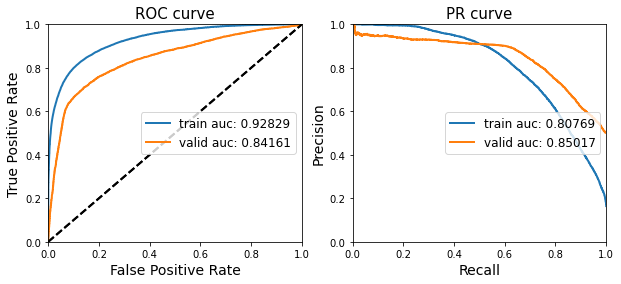

In [26]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][feats], model_df[train_mask].target),
                     (model_df[oot_mask][feats], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['train', 'valid'], thres_method='J')

display(metrics_df)

## Обучение моделей для финального сабмита 

### Модели со всеми фичами и весами

In [28]:
feats_all = [col for col in data.columns if col not in ['target', 'sample']]
cat_cols = ['ProductId', 'LocationId']
data.target = data.target.replace({True: 1, False: 0})
train_data = Pool(data[feats_all], data.target, cat_features=cat_cols, weight=(pd.qcut(np.arange(data.shape[0]), q=(0., 0.75, 0.9, 1.)).codes+4) / 6)

random_states_entropy = [15, 42, 123]
random_states_logloss = [11, 17, 39]
cb_models_all_data = []

for seed in random_states_entropy:
    clf = CatBoostClassifier(
        loss_function='CrossEntropy', 
        random_state=seed,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_models_all_data.append(clf)
    
for seed in random_states_logloss:
    clf = CatBoostClassifier(
        random_state=seed,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1,
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_models_all_data.append(clf)

0:	learn: 0.6126886	total: 77ms	remaining: 23s
100:	learn: 0.2966632	total: 4.44s	remaining: 8.74s
200:	learn: 0.2752179	total: 8.32s	remaining: 4.1s
299:	learn: 0.2618005	total: 11.9s	remaining: 0us
0:	learn: 0.6131526	total: 58.5ms	remaining: 17.5s
100:	learn: 0.2976196	total: 4.04s	remaining: 7.97s
200:	learn: 0.2753324	total: 7.87s	remaining: 3.88s
299:	learn: 0.2623488	total: 11.5s	remaining: 0us
0:	learn: 0.6095592	total: 61.3ms	remaining: 18.3s
100:	learn: 0.2978685	total: 4.12s	remaining: 8.11s
200:	learn: 0.2756503	total: 7.96s	remaining: 3.92s
299:	learn: 0.2628958	total: 11.6s	remaining: 0us
0:	learn: 0.6116627	total: 61.9ms	remaining: 18.5s
100:	learn: 0.2963997	total: 4.09s	remaining: 8.06s
200:	learn: 0.2755543	total: 7.91s	remaining: 3.9s
299:	learn: 0.2612660	total: 11.6s	remaining: 0us
0:	learn: 0.6131242	total: 55.9ms	remaining: 16.7s
100:	learn: 0.2977095	total: 4.25s	remaining: 8.37s
200:	learn: 0.2762581	total: 8.22s	remaining: 4.05s
299:	learn: 0.2621888	total: 12

### Модели без коррелирующих фичей и без весов

In [29]:
feats = [col for col in model_df.columns if col not in ['target', 'sample']]
cat_cols = ['ProductId', 'LocationId']
train_data = Pool(model_df[feats], model_df.target, cat_features=cat_cols)

In [31]:
random_states_entropy = [111, 96, 45]
random_states_logloss = [29, 51, 67]
cb_models_no_corr = []

for seed in random_states_entropy:
    clf = CatBoostClassifier(
        loss_function='CrossEntropy', 
        random_state=seed,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_models_no_corr.append(clf)
    
for seed in random_states_logloss:
    clf = CatBoostClassifier(
        random_state=seed,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_models_no_corr.append(clf)

0:	learn: 0.6126896	total: 48ms	remaining: 14.4s
100:	learn: 0.2929215	total: 3.8s	remaining: 7.49s
200:	learn: 0.2745314	total: 7.32s	remaining: 3.6s
299:	learn: 0.2623342	total: 10.7s	remaining: 0us
0:	learn: 0.6085910	total: 39.6ms	remaining: 11.8s
100:	learn: 0.2928790	total: 3.66s	remaining: 7.21s
200:	learn: 0.2744572	total: 7.12s	remaining: 3.51s
299:	learn: 0.2628221	total: 10.5s	remaining: 0us
0:	learn: 0.6083791	total: 48.4ms	remaining: 14.5s
100:	learn: 0.2928387	total: 3.77s	remaining: 7.43s
200:	learn: 0.2742117	total: 7.31s	remaining: 3.6s
299:	learn: 0.2635210	total: 10.7s	remaining: 0us
0:	learn: 0.6103004	total: 37.4ms	remaining: 11.2s
100:	learn: 0.2935234	total: 3.86s	remaining: 7.61s
200:	learn: 0.2743237	total: 7.46s	remaining: 3.67s
299:	learn: 0.2626044	total: 11s	remaining: 0us
0:	learn: 0.6085405	total: 40.1ms	remaining: 12s
100:	learn: 0.2917785	total: 3.78s	remaining: 7.45s
200:	learn: 0.2730463	total: 7.35s	remaining: 3.62s
299:	learn: 0.2615125	total: 10.9s

### Модели с рандомными фичами

In [34]:
np.random.seed(seed=123)
cb_random_models = []

for i in range(6):
    
    cols = data.drop([target], axis=1).columns.values.copy().tolist()
    np.random.shuffle(cols)
    cols = list(set(['LocationId', 'ProductId', 'timestamp_train']+cols[:40]))
    
    train_data = Pool(data[cols], data.target, cat_features=cat_cols, weight=(pd.qcut(np.arange(data.shape[0]), q=(0., 0.75, 0.9, 1.)).codes+4) / 6)
    
    clf = CatBoostClassifier(
        random_state=15,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1,
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_random_models.append((clf, cols))
    
for i in range(6):
    
    cols = data.drop([target], axis=1).columns.values.copy().tolist()
    np.random.shuffle(cols)
    cols = list(set(['LocationId', 'ProductId', 'timestamp_train']+cols[:40]))
    
    train_data = Pool(data[cols], data.target, cat_features=cat_cols)
    
    clf = CatBoostClassifier(
        random_state=15,
        cat_features=cat_cols,
        iterations=300,
        learning_rate=0.1,
    )
    clf.fit(
        train_data,
        verbose=100,
    )
    cb_random_models.append((clf, cols))

0:	learn: 0.6093179	total: 43.5ms	remaining: 13s
100:	learn: 0.3084892	total: 3.52s	remaining: 6.95s
200:	learn: 0.2910178	total: 6.97s	remaining: 3.43s
299:	learn: 0.2799240	total: 10.4s	remaining: 0us
0:	learn: 0.6068977	total: 34.4ms	remaining: 10.3s
100:	learn: 0.3110935	total: 3.32s	remaining: 6.55s
200:	learn: 0.2935292	total: 6.76s	remaining: 3.33s
299:	learn: 0.2824852	total: 10.1s	remaining: 0us
0:	learn: 0.6102386	total: 39.7ms	remaining: 11.9s
100:	learn: 0.3031225	total: 3.57s	remaining: 7.04s
200:	learn: 0.2851625	total: 6.94s	remaining: 3.42s
299:	learn: 0.2728079	total: 10.2s	remaining: 0us
0:	learn: 0.6066736	total: 30.1ms	remaining: 8.99s
100:	learn: 0.3050948	total: 3.48s	remaining: 6.85s
200:	learn: 0.2877522	total: 6.9s	remaining: 3.4s
299:	learn: 0.2778900	total: 10.3s	remaining: 0us
0:	learn: 0.6121948	total: 35.5ms	remaining: 10.6s
100:	learn: 0.3028141	total: 3.64s	remaining: 7.17s
200:	learn: 0.2869181	total: 7.02s	remaining: 3.46s
299:	learn: 0.2743994	total: 

### Финальный предикт

In [35]:
test_df = pd.read_parquet("test_with_features_final.parquet").drop(['Date', 'LocationId_ProductId', 'timestamp'], axis=1)

test_df.rename(columns={'ValidationDateTime': 'timestamp_train'}, inplace=True)
preds = []

for model in cb_models_all_data:
    preds.append(model.predict_proba(test_df[feats_all])[:, 1])
    
for model in cb_models_no_corr:
    preds.append(model.predict_proba(test_df[feats])[:, 1])
    
for (model, cols)  in cb_random_models:
    preds.append(model.predict_proba(test_df[cols])[:, 1])
    
final_pred = np.array(preds).mean(axis=0)

test_df['CalculatedProbability'] = final_pred
test_df = test_df.rename(columns={'timestamp_train': 'ValidationDatetime'})
subm = test_df[['LocationId', 'ProductId', 'ValidationDatetime', 'CalculatedProbability']].copy()

In [36]:
subm.to_csv("Mr MISISter_2.csv", index=False, sep=';')

### Сохранение моделей

In [39]:
file_to_store = "cb_models_all_data.pickle"
with open(file_to_store, "wb") as f:
    pickle.dump(cb_models_all_data, f)
    
file_to_store = "cb_models_no_corr.pickle"
with open(file_to_store, "wb") as f:
    pickle.dump(cb_models_no_corr, f)
    
file_to_store = "cb_random_models.pickle"
with open(file_to_store, "wb") as f:
    pickle.dump(cb_random_models, f)
    